# Machine Learning Engineer Nanodegree
## Capstone Project - Street View House Numbers
Thomas Wieczorek
January 1st, 2017

## I. Definition
_(approx. 1-2 pages)_

### Project Overview
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_

# //TODO

### Problem Statement
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_

# //TODO

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_

# //TODO

## II. Analysis
_(approx. 2-4 pages)_

### Imports

In [1]:
from urllib.request import urlretrieve
import hashlib
import os
from zipfile import ZipFile
import tarfile

import scipy.io as sio

import matplotlib.pyplot as plt

import os
from scipy.misc import imresize

import random
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

import pandas as pd
from IPython.display import display, HTML

import itertools

# Visualizations will be shown in the notebook.
%matplotlib inline

### Preperations

In [2]:
DEBUG_MODUS = False
LEARN_MODUS = True
DEVICE_NAME = "/cpu:0" #For Training with GPU change to: "/gpu:0"

train_file = "data/train_32x32.mat"
test_file = "data/test_32x32.mat"

### Download

In [3]:
# Based on https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/lab.ipynb
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', train_file)
download('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', test_file)

# Make sure the files aren't corrupted
assert hashlib.md5(open(train_file, 'rb').read()).hexdigest() == 'e26dedcc434d2e4c54c9b2d4a06d8373',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open(test_file, 'rb').read()).hexdigest() == 'eb5a983be6a315427106f1b164d9cef3',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


### Extract

In [4]:
#************** Extract **************#

train_dataset = sio.loadmat(train_file)
test_dataset = sio.loadmat(test_file)

X_train, y_train = train_dataset['X'], train_dataset['y']
X_test, y_test = test_dataset['X'], test_dataset['y']

#*********** Preprocessing ***********#

#Put the images from the last to the first index
X_train = np.transpose(X_train, (3,0,1,2))
X_test = np.transpose(X_test, (3,0,1,2))

#Reshape from (xxx,1) to (xxx)
y_train = np.reshape(y_train, (y_train.shape[0]))
y_test = np.reshape(y_test, (y_test.shape[0]))

# Signs with '0' were marked as '10'. 
# Changing every 10 to 0
y_train[np.where(y_train==10)] = 0
y_test[np.where(y_test==10)] = 0



### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

In [5]:
print("X_train.shape: \t{}".format(X_train.shape))
print("y_train.shape: \t{}".format(y_train.shape))
print("X_test.shape:  \t{}".format(X_test.shape))
print("y_test.shape:  \t{}".format(y_test.shape))

#Number of training examples
n_train = X_train.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#Shape of a house number image?
image_shape = X_train.shape[1:]

# Amount of unique classes/labels there are in the dataset.
n_classes = y_train.ptp() + 1 

print("\nNumber of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

X_train.shape: 	(73257, 32, 32, 3)
y_train.shape: 	(73257,)
X_test.shape:  	(26032, 32, 32, 3)
y_test.shape:  	(26032,)

Number of training examples = 73257
Number of testing examples = 26032
Image data shape = (32, 32, 3)
Number of classes = 10


In [6]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

0


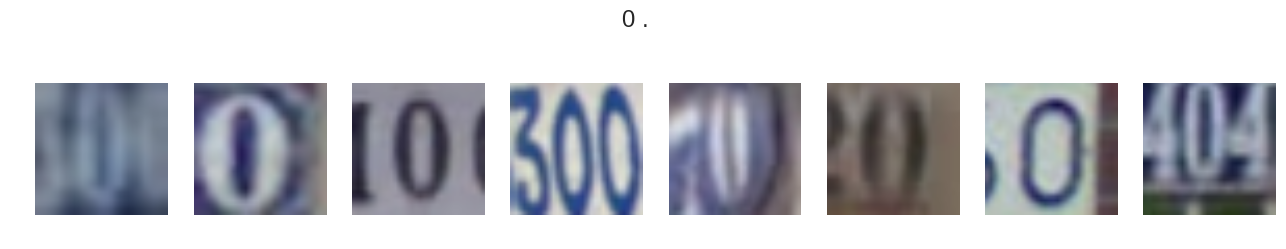

1


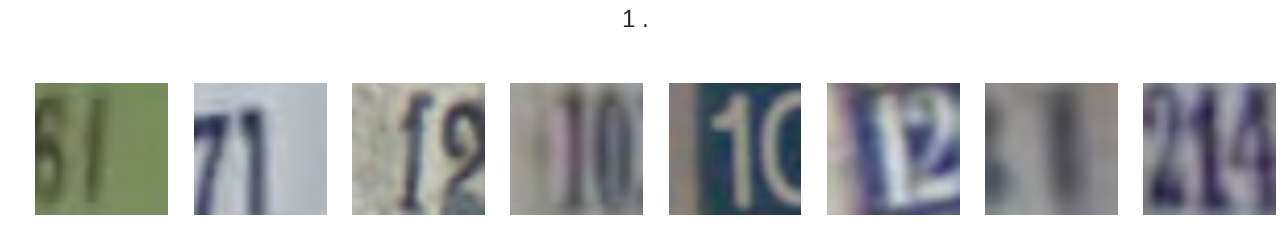

2


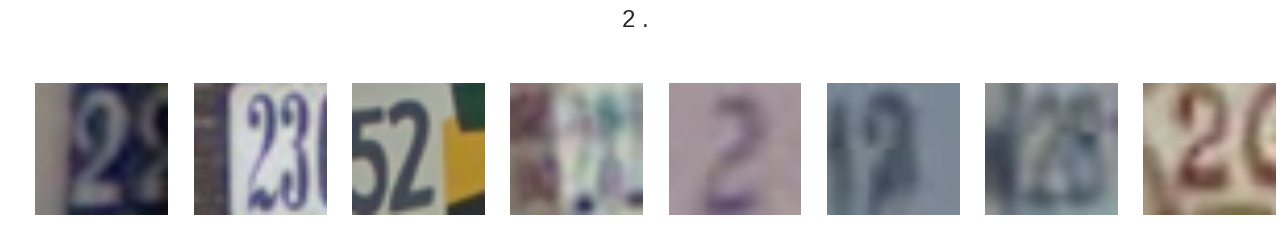

3


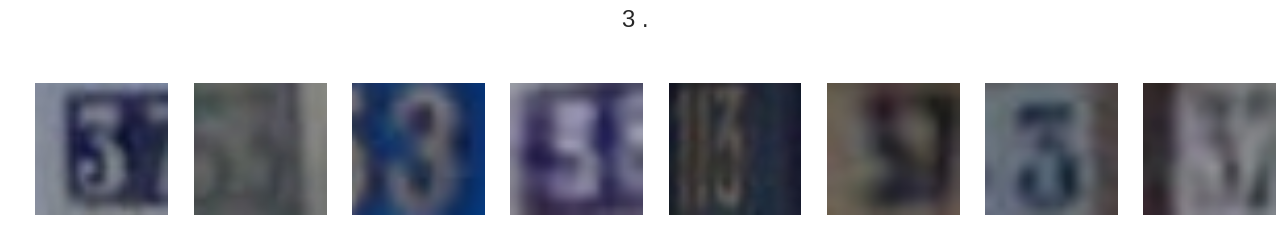

4


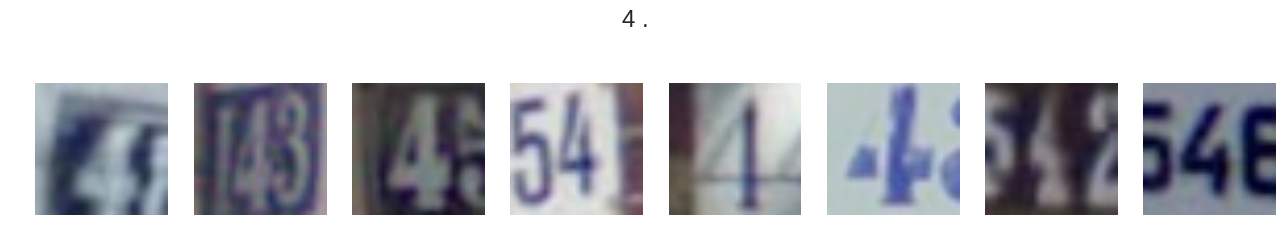

5


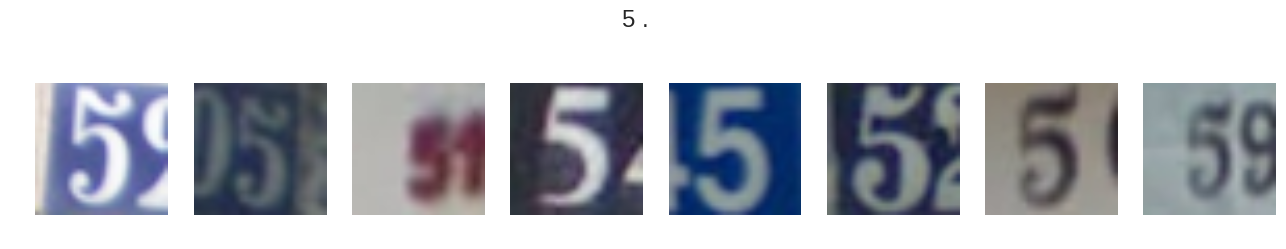

6


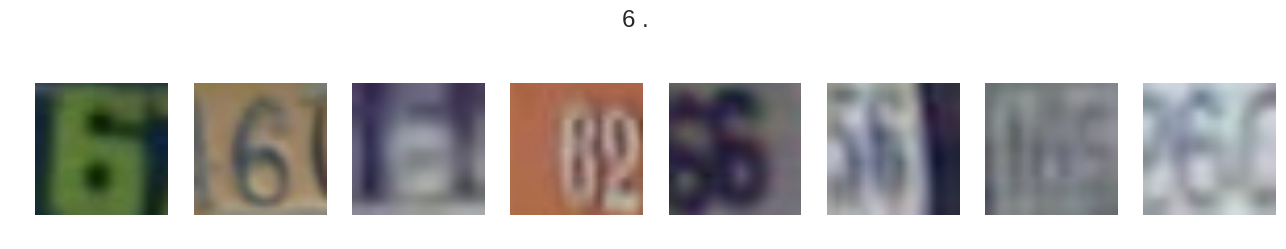

7


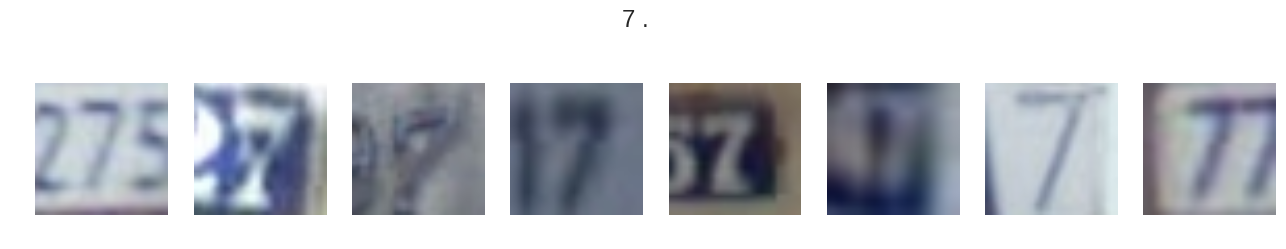

8


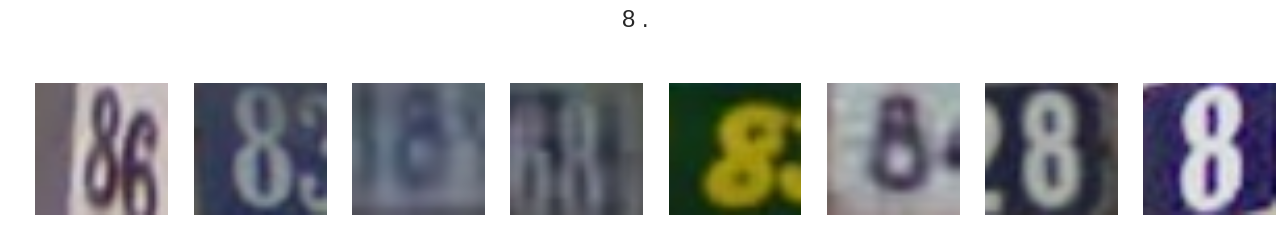

9


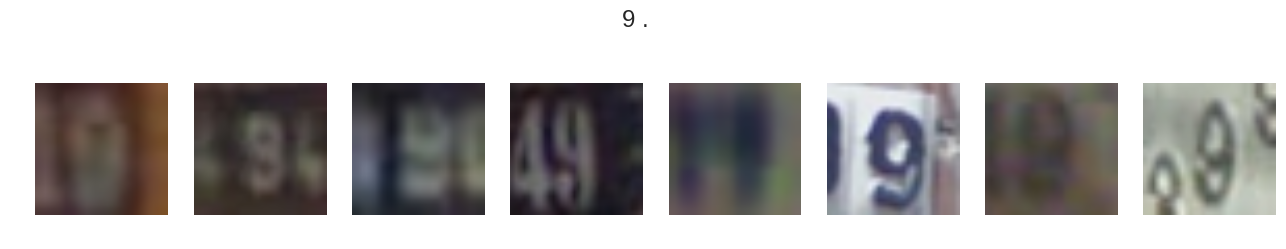

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def visualize_class(classId, num_images = 8):
    """Display a few signs of a single class
    Keyword arguments:
    classID    -- Class ID of the sign
    num_images -- Number of images shown
    """
    
    print(classId)
    examples_train = X_train[np.where(y_train==classId)[0]]
    # pick random index
    idx = np.random.choice(len(examples_train), num_images)
    
    f, ax = plt.subplots(1, num_images, figsize=(16,3))
    f.suptitle("{} .".format(classId), fontsize='xx-large')
    
    for i in range(num_images):     
        ax[i].imshow(examples_train[idx[i]])
        ax[i].axis('off')

    plt.show()

for c in range(n_classes):
    if not DEBUG_MODUS:
        visualize_class(c)

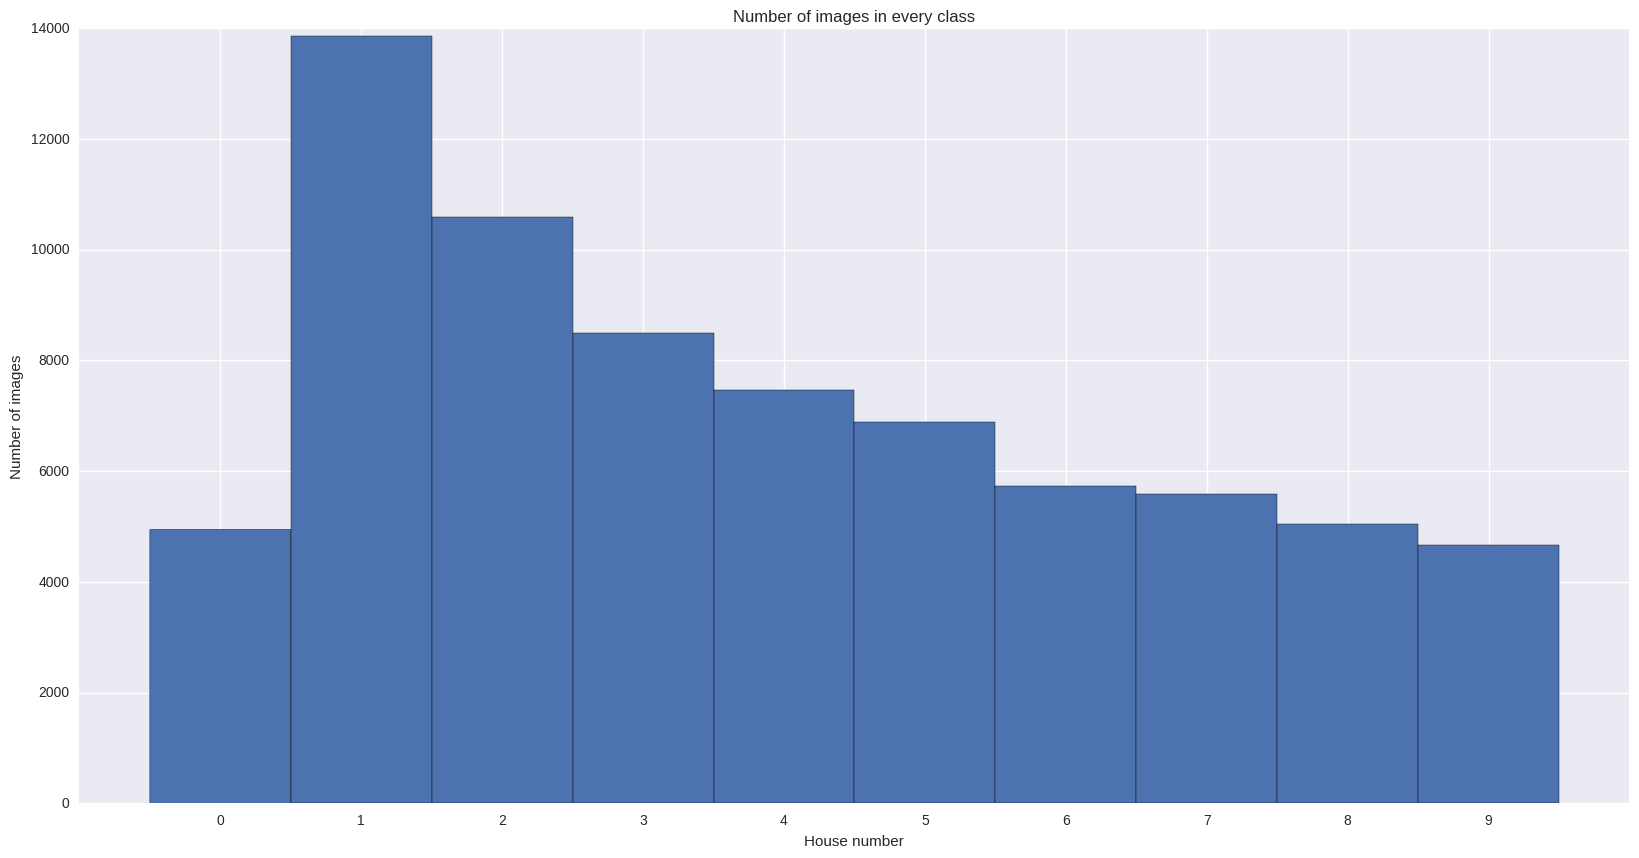

In [8]:
#Histogram of house number occurrences

plt.figure(figsize=(20,10))
plt.hist(y_train, np.arange(n_classes+1) - 0.5) #+1 and -0.5 is for centering labels
plt.xticks(range(n_classes))
plt.xlim([-1, n_classes])
plt.title("Number of images in every class")
plt.ylabel("Number of images")
plt.xlabel("House number")

plt.show()

https://www.wikiwand.com/en/Benford's_law

Plot 5 images from the offset 100


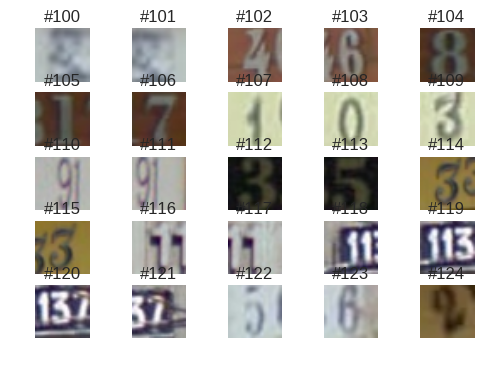

Plot 5 *random* images


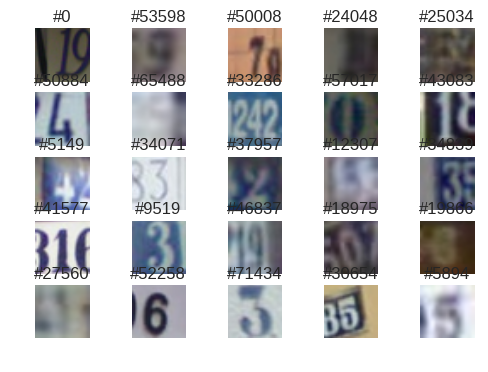

In [9]:
random.seed(datetime.now())

def plot_images(offset = 0, num_images = 5):
    """Plot signs from the offset."""
    print("Plot {} images from the offset {}".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset+i+(a*num_images)
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            
    plt.show()

def plot_random_train(offset = 0, num_images = 5):
    """Plot random signs."""
    print("Plot {} *random* images".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            offset = random.randint(0,len(X_train))
            
    plt.show()

if not DEBUG_MODUS:
    plot_images(offset=100)
    plot_random_train()

### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_


### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


### One Hot 

In [10]:
# One Hot Encoding

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    #Only One Hot Encode once
    is_labels_encod = True

In [11]:
#Check if One-Hot Encoding works
print("y_train.shape: {}".format(y_train.shape))
for i in range(5):
    a=random.randint(0,n_train)
    print("index = {}\n{}".format(a, y_train[a]))
    
print("\n\ny_test.shape: {}".format(y_test.shape))
for i in range(5):
    a=random.randint(0,n_test)
    print("index = {}\n{}".format(a, y_test[a]))

y_train.shape: (73257, 10)
index = 68558
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
index = 63905
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
index = 48623
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
index = 73158
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
index = 61374
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


y_test.shape: (26032, 10)
index = 14074
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
index = 9256
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
index = 14029
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
index = 21213
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
index = 7989
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [12]:
# One Hot to Classnumber
y_test_classes = np.argmax(y_test,1)

In [13]:
print(y_test_classes[:10])

[5 2 1 0 6 1 9 1 1 8]


###  Split in Train, Val and Test

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train )

In [15]:
print("Train size: \t\t{}\nValidiation size: \t{}\nTest size: \t\t{}".format(
        X_train.shape, X_val.shape, X_test.shape))

Train size: 		(49082, 32, 32, 3)
Validiation size: 	(24175, 32, 32, 3)
Test size: 		(26032, 32, 32, 3)


### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_


In [16]:
EPOCHS = 10
BATCH_SIZE = 50

In [17]:
def LeNet(x, keep_prob):

    # 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal([5, 5, 3, 6], stddev = 0.01))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16),stddev = 0.01))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')   

    # Flatten
    fc1 = flatten(conv2)
    # (5 * 5 * 16, 120)

    fc1_W = tf.Variable(tf.truncated_normal([400,120],stddev = 0.01))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes), stddev = 0.01))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc1, fc2_W) + fc2_b

In [18]:
with tf.device(DEVICE_NAME):
    # Data consists of 32x32x3 images
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))

    # Classify over 43 signs
    y = tf.placeholder(tf.float32, (None, n_classes))

    #Keep probability for Dropout
    keep_prob = tf.placeholder(tf.float32)

    #Call LeNet
    fc2 = LeNet(x, keep_prob)

    # Loss
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))

    # Optimizer: AdamOptimizer
    opt = tf.train.AdamOptimizer(learning_rate=0.0002)
    train_op = opt.minimize(loss_op)

    correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    predictions = tf.argmax(fc2,1)

In [19]:
def eval_data(X_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        batch_y = y_data[batch_start:batch_end]
        
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        
    return total_loss/num_examples, total_acc/num_examples


In [45]:
def prediction_in_batches(X_data):
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    preds = np.ndarray(shape=(len(X_data)), dtype=np.float32)
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        
        preds[batch_start:batch_end] = sess.run(predictions, feed_dict={x: batch_x, keep_prob: 1.0})
    
    batch_x = X_data[batch_end+1:len(X_data)-1]
    if not len(batch_x)==0: 
        preds[batch_end+1:len(X_data)-1] = sess.run(predictions, feed_dict={x: batch_x, keep_prob: 1.0})
    return preds

In [21]:
#http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

if __name__ == '__main__':
    if LEARN_MODUS:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_per_epoch = len(X_train) // BATCH_SIZE
            num_examples = steps_per_epoch * BATCH_SIZE

            # Train model
            for i in range(EPOCHS):
                for step in range(steps_per_epoch):
                    #Calculate next Batch
                    batch_start = step * BATCH_SIZE
                    batch_end = (step + 1) * BATCH_SIZE
                    batch_x = X_train[batch_start:batch_end] 
                    batch_y = y_train[batch_start:batch_end]
                    
                    #Run Training
                    loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

                #Calculate Training Loss and Accuracy
                train_loss, train_acc = eval_data(X_train, y_train)
                print("EPOCH {} ...".format(i+1))
                print("Training loss = {:.3f}".format(train_loss))
                print("Training accuracy = {:.3f}".format(train_acc))
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                
                #Calculate Validation Loss and Accuracy
                val_loss, val_acc = eval_data(X_val, y_val)
                print("EPOCH {} ...".format(i+1))
                print("Validation loss = {:.3f}".format(val_loss))
                print("Validation accuracy = {:.3f}".format(val_acc))
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                
                #Calculate Test Loss and Accuracy (Should not be done, because of survivor bias)
                test_loss, test_acc = eval_data(X_test, y_test)
                print("EPOCH {} ...".format(i+1))
                print("Test loss = {:.3f}".format(test_loss))
                print("Test accuracy = {:.3f}".format(test_acc))
                test_losses.append(test_loss)
                test_accuracies.append(test_acc)
            try:
                saver
            except NameError:
                saver = tf.train.Saver()
            saver.save(sess, 'foo')
            print("Model saved")
               

EPOCH 1 ...
Training loss = 1.407
Training accuracy = 0.576
EPOCH 1 ...
Validation loss = 1.417
Validation accuracy = 0.570
EPOCH 1 ...
Test loss = 1.390
Test accuracy = 0.590
EPOCH 2 ...
Training loss = 0.847
Training accuracy = 0.759
EPOCH 2 ...
Validation loss = 0.869
Validation accuracy = 0.752
EPOCH 2 ...
Test loss = 0.890
Test accuracy = 0.751
EPOCH 3 ...
Training loss = 0.723
Training accuracy = 0.793
EPOCH 3 ...
Validation loss = 0.749
Validation accuracy = 0.787
EPOCH 3 ...
Test loss = 0.787
Test accuracy = 0.782
EPOCH 4 ...
Training loss = 0.647
Training accuracy = 0.814
EPOCH 4 ...
Validation loss = 0.676
Validation accuracy = 0.809
EPOCH 4 ...
Test loss = 0.734
Test accuracy = 0.795
EPOCH 5 ...
Training loss = 0.601
Training accuracy = 0.822
EPOCH 5 ...
Validation loss = 0.634
Validation accuracy = 0.815
EPOCH 5 ...
Test loss = 0.696
Test accuracy = 0.802
EPOCH 6 ...
Training loss = 0.547
Training accuracy = 0.836
EPOCH 6 ...
Validation loss = 0.587
Validation accuracy = 0.

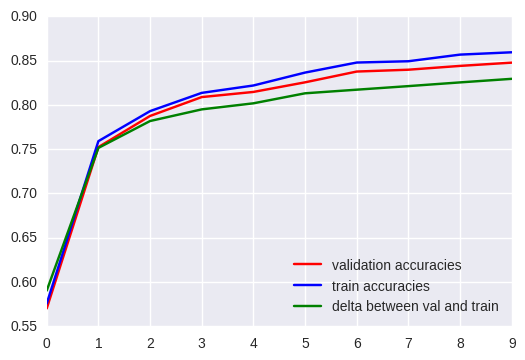

In [22]:
plt.plot(range(EPOCHS), val_accuracies, 'r-',
        range(EPOCHS), train_accuracies, 'b-',
        range(EPOCHS), test_accuracies, 'g-')
        #range(EPOCHS), (list(np.array(val_accuracies) - np.array(train_accuracies))), 'g-')
#plt.plot(train_accuracies)
plt.legend(["validation accuracies", "train accuracies", "delta between val and train"],loc='lower right')
plt.show()

In [23]:
print("Training:\n")
for i, a in enumerate(train_accuracies):
    print("{}: {:.4f}".format(i,a))
    
print("Validation:\n")
for i, a in enumerate(val_accuracies):
    print("{}: {:.4f}".format(i,a))
    
print("Test:\n")
for i, a in enumerate(test_accuracies):
    print("{}: {:.4f}".format(i,a))

Training:

0: 0.5756
1: 0.7590
2: 0.7929
3: 0.8135
4: 0.8219
5: 0.8364
6: 0.8478
7: 0.8492
8: 0.8567
9: 0.8593
Validation:

0: 0.5701
1: 0.7523
2: 0.7875
3: 0.8088
4: 0.8146
5: 0.8254
6: 0.8376
7: 0.8397
8: 0.8440
9: 0.8477
Test:

0: 0.5903
1: 0.7514
2: 0.7817
3: 0.7949
4: 0.8017
5: 0.8130
6: 0.8171
7: 0.8212
8: 0.8253
9: 0.8294


In [53]:
#new_graph = tf.Graph()
#with tf.Session(graph=new_graph) as sess:

try:
    saver
except NameError:
    saver = tf.train.Saver()
#    with tf.Session() as sess:
#        saver.restore(sess, './vggsmall-20')


with tf.Session() as sess:   
    #sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('foo.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_loss, test_acc = eval_data(X_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))

    predicted_classes = np.array(prediction_in_batches(X_test))

Test loss = 0.615
Test accuracy = 0.829


In [52]:
print(predicted_classes[-20:])
print(y_test_classes.shape)

[ 1.  8.  3.  3.  4.  2.  5.  9.  1.  5.  1.  7.  1.  3.  6.  2.  2.  7.
  6.  0.]
(26032,)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    if not normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
print(y_test_classes.shape)
print(predicted_classes.shape)

# Create Confusion Matrix
cnf_matrix = confusion_matrix(y_test_classes, predicted_classes)

# Plot Confusion Matrix
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))

#Plot with Number
plot_confusion_matrix(cnf_matrix,classes=range(n_classes),
                      title='Confusion matrix, without normalization')

plt.show()


### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


In [ ]:
index_five = [142, 1542, 2842, 3024, 4442]
test_five = X_test[index_five]
sess = tf.Session()

predicted_classes = []

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
       
    predicted_classes = sess.run(predictions, feed_dict={x: test_five, keep_prob: 1.0})

In [ ]:
f, ax = plt.subplots(len(index_five), 1, figsize=(12.0, 25.0))
f.subplots_adjust(hspace=.5)
for i, idx in enumerate(index_five):    
    #Plot Image
    ax[i].imshow(X_test[idx])
    ax[i].set_title("{} \n Predicted Class: {} - {} \n Real Class: {} - {}".format(index_five[i], predicted_classes[i], sign_names['SignName'][predicted_classes[i]], y_test_classes[idx], sign_names['SignName'][y_test_classes[idx]]))
 
 
plt.plot()


### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_


### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_


### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_


-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?